In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

# Load datasets
- casussen contains the age, gender and area per infection including a date.
- maatregelen contains information on dutch social distancing measures start date and end date.

In [25]:
# laad datasets in
# casussen
casussen = pd.read_csv('https://data.rivm.nl/covid-19/COVID-19_casus_landelijk.csv', sep=';', parse_dates=['Date_statistics'])

# maatregelen
maatregelen = pd.read_csv('https://www.ecdc.europa.eu/sites/default/files/documents/response_graphs_data_2021-03-25.csv', sep=','
                         , parse_dates=['date_start', 'date_end'])


maatregelen = maatregelen[maatregelen['Country'] == 'Netherlands'].fillna(pd.to_datetime("today").normalize())


maatregelen_agg = pd.DataFrame(pd.date_range(start='01-01-2020', end=pd.to_datetime("today").normalize(), freq='d'), columns=['date'])
# create a dummy key with which we can join all projects with all dates

# create a dummy key with which we can join all projects with all dates
# maatregelen['key'] = 'key'
# maatregelen_agg['key'] = 'key'
maatregelen_agg = pd.merge(maatregelen, maatregelen_agg, how='cross')# on=['key'])

# check if date is within project dates
maatregelen_agg['count_measures'] = maatregelen_agg['date'].ge(maatregelen_agg['date_start']) & maatregelen_agg['date'].le(maatregelen_agg['date_end'])

# group per day: count all open projects
maatregelen_agg = maatregelen_agg.groupby(
    'date', as_index=False)['count_measures'].sum()

# Calculate date of infection 
AKA subtract incubation period, testing delay and reporting delay

In [26]:
# 3 day reporting delay + 2 day testing delay (hartl et al., 2020; wieland, 2020)
casussen.loc[casussen['Date_statistics_type'] == 'DON', 'adjusted_onset'] = casussen['Date_statistics'] - pd.to_timedelta(5, unit='d')

# 2 day testing delay (hartl et al., 2020)
casussen.loc[casussen['Date_statistics_type'] == 'DPL', 'adjusted_onset'] = casussen['Date_statistics'] - pd.to_timedelta(2, unit='d')

# 5 day incubation period (Lauer et al., 2020; Linton et al., 2020)
casussen.loc[casussen['Date_statistics_type'] == 'DOO', 'adjusted_onset'] = casussen['Date_statistics']
casussen['Infection_date'] = casussen['adjusted_onset'] - pd.to_timedelta(5, unit='d') #incubation period (wieland, 2020)


# Calculate daily infections and infection rate

In [27]:
# groepeer per dag
temp = casussen.groupby('Infection_date').count().rename(columns={'Agegroup':'No_cases'})['No_cases']

# fill missing dates with 0
idxtemp = pd.date_range(temp.index.min()-pd.to_timedelta(14, unit='d'), temp.index.max()+pd.to_timedelta(14, unit='d'))# widen frame to roll correctly during R
# idx = pd.date_range(temp.index.min(), temp.index.max()-pd.to_timedelta(14, unit='d')) # remove most recent 14 days due to incompleteness
temp.index = pd.DatetimeIndex(temp.index)
temp = temp.reindex(idxtemp, fill_value=0).to_frame()

# calculate r using RKI
temp['4dayrollingsum'] = temp.rolling(4).sum() 
temp['4dayrollingsum-4'] = np.roll(temp['4dayrollingsum'], shift=4)
temp = temp.fillna(0)
temp['R'] = temp['4dayrollingsum']/temp['4dayrollingsum-4']
temp = temp.replace([np.inf, np.nan], 1)

# first day with 100 cases
start_covid_NL = temp[temp['No_cases']>100].index[0]
# start_covid_NL = pd.to_datetime('2020-02-25')
today = pd.to_datetime("today").normalize()
end_analysis = pd.to_datetime('2021-05-06')

# control for weekly fluctuations
temp['Rolling_R'] = temp['R'].rolling(15, center=True, win_type='gaussian').mean(std=3) # haug et al.

# define relevant dates for analysis
temp['Relevant'] = (temp.index >= start_covid_NL) & (temp.index <= end_analysis)

vandaag = today.strftime('%Y-%m-%d')

# export temp file
# temp.reset_index().rename(columns={'index':'Date'}).to_csv(f'Daily R Netherlands {vandaag}.csv', index=False)

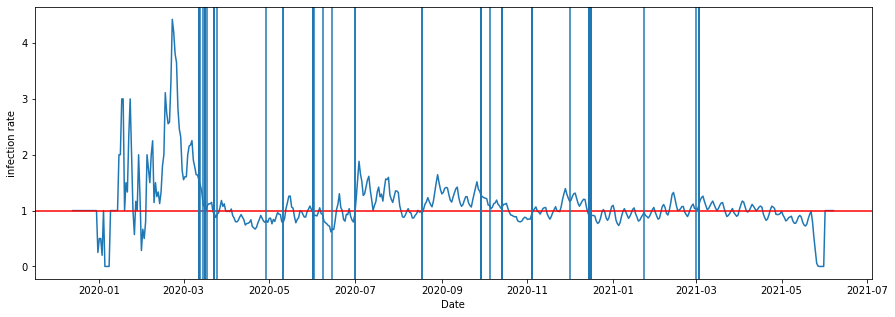

In [28]:
# plot
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.set_xlabel('Date')
ax1.set_ylabel('infection rate')
ax1.plot(temp.index, 
         temp['R'], label='Reproduction number')
plt.axhline(y=1, color='r', linestyle='-')

for i, row in maatregelen.iterrows():
    plt.axvline(row['date_start'])
# plt.axvspan(today-pd.to_timedelta(14, unit='d'), today, alpha=0.5, color='grey')

# Categorize measures including intensity

In [29]:
# categorize measures (incl. intensity)
# manually adjust lockdown and inset normal stayhome
maatregelen.loc[maatregelen['Response_measure'] == 'StayHomeOrderPartial', 'date_end'] = pd.to_datetime('2021-04-27').normalize()
new_row = {'Response_measure':'StayHomeGen', 'date_start':pd.to_datetime('2021-04-27').normalize(), 
           'date_end':pd.to_datetime("today").normalize()}
maatregelen = maatregelen.append(new_row, ignore_index=True)

# group measures
maatregelen.loc[maatregelen['Response_measure'].str.contains('Events', case=False), 'L3'] = 'Events'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Masks', case=False), 'L3'] = 'Masks'
maatregelen.loc[maatregelen['Response_measure'].str.contains('MassGatherAll', case=False), 'L3'] = 'MassGatherAll'
maatregelen.loc[maatregelen['Response_measure'].str.contains('MassGather50', case=False), 'L3'] = 'MassGather50'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Transport', case=False), 'L3'] = 'Transport'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Indoor', case=False), 'L3'] = 'Indoor'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Outdoor', case=False), 'L3'] = 'Outdoor'
maatregelen.loc[maatregelen['Response_measure'].str.contains('PrivateGathering', case=False), 'L3'] = 'Gatherings'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Stayhome', case=False), 'L3'] = 'StayHome'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Gym', case=False), 'L3'] = 'Sports'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Prim', case=False), 'L3'] = 'Primary Education'
maatregelen.loc[maatregelen['Response_measure'].str.contains('High', case=False), 'L3'] = 'Higher Education'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Sec', case=False), 'L3'] = 'Secondary Education'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Daycare', case=False), 'L3'] = 'Daycare'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Entertainment', case=False), 'L3'] = 'Entertainment'
maatregelen.loc[maatregelen['Response_measure'].str.contains('cafes', case=False), 'L3'] = 'Restaurant/Cafes'
maatregelen.loc[maatregelen['Response_measure'].str.contains('PubAny', case=False), 'L3'] = 'Restaurant/Cafes'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Worship', case=False), 'L3'] = 'Religion'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Work', case=False), 'L3'] = 'Workplace'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Telework', case=False), 'L3'] = 'Telework'
# maatregelen.loc[maatregelen['Response_measure'].str.contains('Adaptation', case=False), 'L3'] = 'Workplace'
maatregelen.loc[maatregelen['Response_measure'].str.contains('Shops', case=False), 'L3'] = 'Shops'

# Closure of educational institutions
maatregelen.loc[maatregelen['L3'].str.contains('Education', case=False), 'L2'] = 'Closure of educational institutions'
# Indoor and outdoor gathering restriction
maatregelen.loc[maatregelen['L3'].isin(['Events', 'MassGatherAll', 'MassGather50', 'Gatherings']), 'L2'] = 'Indoor and outdoor gathering restriction'
# Indoor gathering restriction
maatregelen.loc[maatregelen['L3'].isin(['Indoor', 'Masks']), 'L2'] = 'Indoor gathering restriction'
# Measures for public transport
maatregelen.loc[maatregelen['L3'].isin(['Transport']), 'L2'] = 'Measures for public transport'
# Measures for special populations
maatregelen.loc[maatregelen['L3'].isin(['StayHome']), 'L2'] = 'Measures for special populations'
# Outdoor gathering restriction
maatregelen.loc[maatregelen['L3'].isin(['Outdoor']), 'L2'] = 'Outdoor gathering restriction'
# Special measures for certain establishments
maatregelen.loc[maatregelen['L3'].isin(['Daycare', 'Restaurant/Cafes', 'Entertainment', 'Sports', 'Shops', 'Religion']), 'L2'] = 'Special measures for certain establishments'
# Work safety protocols
maatregelen.loc[maatregelen['L3'].str.contains('Work', case=False), 'L2'] = 'Special measures for certain establishments'

# general rule for severity is top level and partial lowest
maatregelen['Degree'] = 2
maatregelen.loc[maatregelen['Response_measure'].str.contains('Partial', case=False), 'Degree'] = 1

# adjust measures that differ
maatregelen.loc[maatregelen['Response_measure'] == 'StayHomeGen', 'Degree'] = 3
maatregelen.loc[maatregelen['Response_measure'] == 'StayHomeGenPartial', 'Degree'] = 2
maatregelen.loc[maatregelen['Response_measure'] == 'StayHomeOrderPartial', 'Degree'] = 4
maatregelen.loc[maatregelen['Response_measure'] == 'StayHomeRiskG', 'Degree'] = 1
maatregelen.loc[maatregelen['Response_measure'] == 'IndoorOver100', 'Degree'] = 1
maatregelen.loc[maatregelen['Response_measure'] == 'MasksVoluntaryClosedSpacesPartial', 'Degree'] = 3
maatregelen.loc[maatregelen['Response_measure'] == 'OutdoorOver500', 'Degree'] = 1
maatregelen.loc[maatregelen['Response_measure'] == 'OutdoorOver50', 'Degree'] = 3


maatregelen = maatregelen.reset_index()[['Response_measure', 'date_start', 'date_end', 'L2', 'L3', 'Degree']]

display(maatregelen)

,Response_measure,date_start,date_end,L2,L3,Degree
0,AdaptationOfWorkplace,2020-03-25,2021-05-31,Special measures for certain establishments,Workplace,2
1,BanOnAllEvents,2020-03-23,2020-05-31,Indoor and outdoor gathering restriction,Events,2
2,BanOnAllEvents,2020-11-04,2021-05-31,Indoor and outdoor gathering restriction,Events,2
3,BanOnAllEventsPartial,2020-10-14,2020-11-03,Indoor and outdoor gathering restriction,Events,1
4,ClosDaycare,2020-03-16,2020-05-10,Special measures for certain establishments,Daycare,2
...,...,...,...,...,...,...
65,TeleworkingPartial,2020-06-01,2020-08-17,Special measures for certain establishments,Telework,1
66,WorkplaceClosures,2020-03-23,2020-05-10,Special measures for certain establishments,Workplace,2
67,WorkplaceClosures,2020-12-15,2021-03-02,Special measures for certain establishments,Workplace,2
68,WorkplaceClosuresPartial,2021-03-03,2021-05-31,Special measures for certain establishments,Workplace,1


# Create correct format of interventions

In [30]:
# dummify response measures to daily
dummies = pd.get_dummies(maatregelen, columns=['Response_measure'], dtype=bool, prefix='', prefix_sep='')
dates = pd.DataFrame(pd.date_range(start_covid_NL, end_analysis), columns=['Date'])

# create temp key to cross join
dates['key'] = 0
dummies['key'] = 0
temp3 = dates.merge(dummies, on='key', how='outer')

# clean dataset and aggregate to daily
temp3 = temp3[(temp3['Date'] >= temp3['date_start']) & (temp3['Date'] <= temp3['date_end'])]
measureset = temp3.groupby('Date').max().drop(['key', 'date_start', 'date_end', 'L2', 'L3', 'Degree'], 
                                              axis=1).reindex(temp.index).fillna(False)
# change true values to the degree of the measure
new_maatregelen = measureset.copy()
for column in new_maatregelen.columns:
    new_maatregelen.loc[new_maatregelen[column] == True, column] = maatregelen[maatregelen['Response_measure'] == column]['Degree'].iloc[0] 

# combine groups
test = pd.DataFrame()
test['Workplace'] = new_maatregelen[['WorkplaceClosures', 'WorkplaceClosuresPartial', 'AdaptationOfWorkplace']].max(axis=1)
test['Events'] = new_maatregelen[['BanOnAllEvents', 'BanOnAllEventsPartial']].max(axis=1)
test['Daycare'] = new_maatregelen[['ClosDaycare', 'ClosDaycarePartial']].max(axis=1)
test['Higher Education'] = new_maatregelen[['ClosHigh', 'ClosHighPartial']].max(axis=1)
test['Secondary Education'] = new_maatregelen[['ClosSec', 'ClosSecPartial']].max(axis=1)
test['Primary Education'] = new_maatregelen[['ClosPrim', 'ClosPrimPartial']].max(axis=1)
test['Restaurants/Cafes'] = new_maatregelen[['ClosPubAny', 'ClosPubAnyPartial', 'RestaurantsCafes', 'RestaurantsCafesPartial']].max(axis=1)
test['Transport'] = new_maatregelen[['ClosureOfPublicTransportPartial']].max(axis=1)
test['Entertainment'] = new_maatregelen[['EntertainmentVenues', 'EntertainmentVenuesPartial']].max(axis=1)
test['Sports'] = new_maatregelen[['GymsSportsCentres', 'GymsSportsCentresPartial']].max(axis=1)
test['Indoor'] = new_maatregelen[['IndoorOver100', 'IndoorOver50']].max(axis=1)
test['Masks'] = new_maatregelen[['MasksMandatoryClosedSpaces', 'MasksMandatoryClosedSpacesPartial', 'MasksVoluntaryClosedSpacesPartial']].max(axis=1)
test['MassGather50'] = new_maatregelen[['MassGather50', 'MassGather50Partial']].max(axis=1)
test['MassGatherAll'] = new_maatregelen[['MassGatherAll', 'MassGatherAllPartial']].max(axis=1)
test['Shops'] = new_maatregelen[['NonEssentialShops', 'NonEssentialShopsPartial']].max(axis=1)
test['Outdoor'] = new_maatregelen[['OutdoorOver100', 'OutdoorOver50', 'OutdoorOver500']].max(axis=1)
test['Religion'] = new_maatregelen[['PlaceOfWorship', 'PlaceOfWorshipPartial']].max(axis=1)
test['Gatherings'] = new_maatregelen[['PrivateGatheringRestrictions']].max(axis=1)
test['Stayhome'] = new_maatregelen[['StayHomeGen', 'StayHomeGenPartial', 'StayHomeOrderPartial', 'StayHomeRiskG']].max(axis=1)
test['Telework'] = new_maatregelen[['Teleworking', 'TeleworkingPartial']].max(axis=1)
        
display(test)  

,Workplace,Events,Daycare,Higher Education,Secondary Education,Primary Education,Restaurants/Cafes,Transport,Entertainment,Sports,Indoor,Masks,MassGather50,MassGatherAll,Shops,Outdoor,Religion,Gatherings,Stayhome,Telework
2019-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# join with infection and vacinnation set selecting relevant training points
new_dataset = temp.merge(test, left_index=True, right_index=True, how='outer')
new_dataset = new_dataset[new_dataset['Relevant']].drop(['4dayrollingsum', '4dayrollingsum-4', 'R', 'Relevant'], axis=1)

# vacinnation
vacinnaties = pd.read_csv('Data/vacinnaties.csv', sep=';')
vacinnaties['Datum'] = pd.to_datetime(vacinnaties['Datum'], dayfirst=True)
vacinnaties = vacinnaties.set_index('Datum')
vacinnaties['Prikken'] = vacinnaties['Prikken'].str.replace('.','').astype(int)

new_dataset = new_dataset.merge(vacinnaties, left_index=True, right_index=True, how='left').fillna(0)
display(new_dataset.tail())

# export training set
new_dataset.reset_index().rename({'index':'Date'}, axis=1).to_csv('Data/statsmodels.csv', sep=';')

# create relative set (e.g. max = 1 of all columns)
rel = new_dataset.copy().drop('Rolling_R', axis=1)
rel = rel/rel.max()
rel['Rolling_R'] = new_dataset['Rolling_R']
display(rel.tail())

# export rel training set
rel.reset_index().rename({'index':'Date'}, axis=1).to_csv('Data/statsmodels rel.csv', sep=';')


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


,No_cases,Rolling_R,Workplace,Events,Daycare,Higher Education,Secondary Education,Primary Education,Restaurants/Cafes,Transport,...,Masks,MassGather50,MassGatherAll,Shops,Outdoor,Religion,Gatherings,Stayhome,Telework,Prikken
2021-05-02,5753,0.907408,2.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,2.0,3.0,2.0,5651041.0
2021-05-03,5716,0.893238,2.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,2.0,3.0,2.0,5757731.0
2021-05-04,5336,0.880369,2.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,2.0,3.0,2.0,5860446.0
2021-05-05,5936,0.869616,2.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,2.0,3.0,2.0,5980676.0
2021-05-06,5365,0.860512,2.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,2.0,3.0,2.0,6101271.0


,No_cases,Workplace,Events,Daycare,Higher Education,Secondary Education,Primary Education,Restaurants/Cafes,Transport,Entertainment,...,MassGather50,MassGatherAll,Shops,Outdoor,Religion,Gatherings,Stayhome,Telework,Prikken,Rolling_R
2021-05-02,0.457531,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,1.0,1.0,0.5,0.0,0.0,1.0,0.75,1.0,0.926207,0.907408
2021-05-03,0.454589,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,1.0,1.0,0.5,0.0,0.0,1.0,0.75,1.0,0.943694,0.893238
2021-05-04,0.424368,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,1.0,1.0,0.5,0.0,0.0,1.0,0.75,1.0,0.960529,0.880369
2021-05-05,0.472085,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,1.0,1.0,0.5,0.0,0.0,1.0,0.75,1.0,0.980234,0.869616
2021-05-06,0.426674,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,1.0,1.0,0.5,0.0,0.0,1.0,0.75,1.0,1.000000,0.860512


# Create datafile for time series/breakpoint analysis

In [34]:
breakpoint = temp[temp['Relevant']][['No_cases', 'Rolling_R']].rename({'No_cases':'Daily infections'}, axis=1)
breakpoint['Cum_cases'] = breakpoint['Daily infections'].cumsum()
breakpoint.reset_index().rename({'index':'Date'}, axis=1).to_csv('Data/breakpoint.csv', sep=';')

# Create datafile for deeper analysis

In [71]:
gender = casussen.groupby(['Infection_date', 'Sex']).count()['Agegroup'].reset_index().pivot_table(
    index='Infection_date', columns='Sex', aggfunc=np.sum, margins=True).reindex(temp.index).fillna(0)
gender.columns = gender.columns.droplevel()

gender['perc_F'] = gender['Female']/gender['All']
gender['perc_M'] = gender['Male']/gender['All']

gender['Relevant'] = (temp.index >= start_covid_NL) & (temp.index <= end_analysis)

gender[gender['Relevant']].head()

Sex,Female,Male,Unknown,All,perc_F,perc_M,Relevant
2020-02-25,77.0,58.0,0.0,135.0,0.570370,0.429630,True
2020-02-26,69.0,73.0,0.0,142.0,0.485915,0.514085,True
2020-02-27,58.0,72.0,0.0,130.0,0.446154,0.553846,True
2020-02-28,73.0,67.0,0.0,140.0,0.521429,0.478571,True
2020-02-29,81.0,85.0,1.0,167.0,0.485030,0.508982,True


In [73]:
age = casussen.groupby(['Infection_date', 'Agegroup']).count()['Sex'].reset_index().pivot_table(
    index='Infection_date', columns='Agegroup', aggfunc=np.sum, margins=True).reindex(temp.index).fillna(0)
age.columns = age.columns.droplevel()
age['Relevant'] = (temp.index >= start_covid_NL) & (temp.index <= end_analysis)

age['under_30'] = (age['0-9']+age['10-19']+age['20-29']) 
age['perc_under_30'] = age['under_30']/age['All']

age[age['Relevant']]

Agegroup,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+,<50,Unknown,All,Relevant,under_30,perc_under_30
2020-02-25,1.0,8.0,9.0,6.0,31.0,32.0,16.0,18.0,13.0,1.0,0.0,0.0,135.0,True,18.0,0.133333
2020-02-26,1.0,6.0,4.0,14.0,27.0,28.0,26.0,16.0,17.0,3.0,0.0,0.0,142.0,True,11.0,0.077465
2020-02-27,0.0,4.0,16.0,11.0,21.0,31.0,20.0,14.0,8.0,5.0,0.0,0.0,130.0,True,20.0,0.153846
2020-02-28,1.0,6.0,10.0,12.0,12.0,31.0,27.0,26.0,14.0,1.0,0.0,0.0,140.0,True,17.0,0.121429
2020-02-29,0.0,4.0,7.0,7.0,26.0,44.0,34.0,24.0,18.0,3.0,0.0,0.0,167.0,True,11.0,0.065868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-02,309.0,869.0,1148.0,794.0,923.0,988.0,448.0,225.0,35.0,14.0,0.0,0.0,5753.0,True,2326.0,0.404311
2021-05-03,316.0,965.0,1089.0,803.0,793.0,1003.0,475.0,214.0,50.0,8.0,0.0,0.0,5716.0,True,2370.0,0.414626
2021-05-04,316.0,957.0,1048.0,735.0,787.0,879.0,365.0,208.0,34.0,7.0,0.0,0.0,5336.0,True,2321.0,0.434970
2021-05-05,309.0,1015.0,1247.0,810.0,865.0,971.0,427.0,218.0,56.0,18.0,0.0,0.0,5936.0,True,2571.0,0.433120


In [69]:
prov = casussen.groupby(['Infection_date', 'Province']).count()['Sex'].reset_index().pivot_table(
    index='Infection_date', columns='Province', aggfunc=np.sum, margins=True).reindex(temp.index).fillna(0)
prov.columns = prov.columns.droplevel()
prov['Relevant'] = (temp.index >= start_covid_NL) & (temp.index <= end_analysis)

prov['randstad'] = (prov['Noord-Holland']+prov['Zuid-Holland']+prov['Utrecht']) 
prov['perc_randstad'] = prov['randstad']/prov['All']

prov[prov['Relevant']]

Province,Drenthe,Flevoland,Fryslân,Gelderland,Groningen,Limburg,Noord-Brabant,Noord-Holland,Overijssel,Utrecht,Zeeland,Zuid-Holland,All,Relevant,randstad,perc_randstad
2020-02-25,2.0,1.0,0.0,16.0,1.0,6.0,50.0,10.0,5.0,24.0,1.0,19.0,135.0,True,53.0,0.392593
2020-02-26,0.0,1.0,1.0,13.0,1.0,19.0,47.0,16.0,5.0,19.0,4.0,16.0,142.0,True,51.0,0.359155
2020-02-27,1.0,2.0,4.0,9.0,2.0,12.0,47.0,16.0,7.0,9.0,1.0,20.0,130.0,True,45.0,0.346154
2020-02-28,3.0,1.0,0.0,20.0,0.0,18.0,52.0,15.0,4.0,10.0,2.0,15.0,140.0,True,40.0,0.285714
2020-02-29,2.0,1.0,1.0,15.0,1.0,18.0,66.0,20.0,8.0,8.0,4.0,23.0,167.0,True,51.0,0.305389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-02,101.0,116.0,139.0,737.0,102.0,456.0,1086.0,797.0,424.0,407.0,142.0,1246.0,5753.0,True,2450.0,0.425865
2021-05-03,105.0,122.0,159.0,678.0,106.0,479.0,1032.0,727.0,399.0,432.0,113.0,1364.0,5716.0,True,2523.0,0.441393
2021-05-04,93.0,129.0,148.0,672.0,117.0,442.0,938.0,685.0,378.0,409.0,111.0,1214.0,5336.0,True,2308.0,0.432534
2021-05-05,108.0,117.0,159.0,694.0,116.0,496.0,1048.0,778.0,424.0,442.0,139.0,1415.0,5936.0,True,2635.0,0.443902


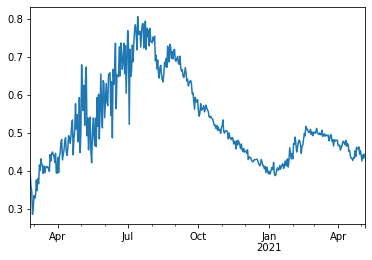

In [58]:
prov[prov['Relevant']]['perc_randstad'].plot()

In [76]:
rel2 = rel.merge(prov['perc_randstad'], how='left', left_index=True, right_index=True)
rel2 = rel2.merge(age['perc_under_30'], how='left', left_index=True, right_index=True)
rel2 = rel2.merge(gender['perc_M'], how='left', left_index=True, right_index=True)
rel2

rel2.reset_index().rename({'index':'Date'}, axis=1).to_csv('Data/statsmodels deep rel.csv', sep=';')

In [77]:
rel2

,No_cases,Workplace,Events,Daycare,Higher Education,Secondary Education,Primary Education,Restaurants/Cafes,Transport,Entertainment,...,Outdoor,Religion,Gatherings,Stayhome,Telework,Prikken,Rolling_R,perc_randstad,perc_under_30,perc_M
2020-02-25,0.010736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,3.135478,0.392593,0.133333,0.429630
2020-02-26,0.011293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,2.914854,0.359155,0.077465,0.514085
2020-02-27,0.010339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,2.665937,0.346154,0.153846,0.553846
2020-02-28,0.011134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,2.422609,0.285714,0.121429,0.478571
2020-02-29,0.013281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,2.213714,0.305389,0.065868,0.508982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-02,0.457531,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.75,1.0,0.926207,0.907408,0.425865,0.404311,0.504085
2021-05-03,0.454589,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.75,1.0,0.943694,0.893238,0.441393,0.414626,0.506298
2021-05-04,0.424368,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.75,1.0,0.960529,0.880369,0.432534,0.434970,0.513306
2021-05-05,0.472085,1.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.75,1.0,0.980234,0.869616,0.443902,0.433120,0.517352
